In [ ]:
# Importing packages
! pip install astroquery astropy pandas

# --------------------------------------------------------
# Batch fetch asteroid ephemerides from JPL Horizons
# Shivanshu Dwivedi | Trinity College
# --------------------------------------------------------

from astroquery.jplhorizons import Horizons
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import sleep

# --------------------------------------------------------
# 1. Config
# --------------------------------------------------------
DATASET_PATH = "./data/raw/dataset.csv"   
SAVE_DIR     = "./data/processed"
os.makedirs(SAVE_DIR, exist_ok=True)

START_DATE   = "2024-10-02"
STOP_DATE    = "2024-12-01"
STEP_SIZE    = "1h"     # or "1h"
CENTER       = "@0"     # Solar System Barycenter
REFPLANE     = "ecliptic"

# --------------------------------------------------------
# 2. Load asteroid catalog
# --------------------------------------------------------
catalog = pd.read_csv(DATASET_PATH)
print("Catalog loaded. Shape:", catalog.shape)
catalog.head()


DEPRECATION: Loading egg at /Users/shivanshu/anaconda3/lib/python3.11/site-packages/mesa_reader-0.3.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


/var/folders/84/c1f888hj3nl61gx1s2sy_krc0000gn/T/ipykernel_29226/2049194941.py:31: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  catalog = pd.read_csv(DATASET_PATH)


Catalog loaded. Shape: (958524, 45)


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [2]:
# --------------------------------------------------------
# 3. User Selection
# --------------------------------------------------------

# Option 1: Fetch the first N asteroids
N = 5   

# Option 2: Specify asteroid IDs manually (e.g., [1, 2, 4, 433])
SELECTED = []  

if SELECTED:
    asteroids = catalog[catalog['pdes'].isin(SELECTED)]
else:
    asteroids = catalog.head(N)

print("Fetching these asteroids:")
print(asteroids[['pdes','full_name','name']])


Fetching these asteroids:
  pdes       full_name     name
0    1         1 Ceres    Ceres
1    2        2 Pallas   Pallas
2    3          3 Juno     Juno
3    4         4 Vesta    Vesta
4    5       5 Astraea  Astraea


In [3]:
# --------------------------------------------------------
# 4. Fetch Function
# --------------------------------------------------------
def fetch_vectors(identifier, start, stop, step="1d", center="@0", refplane="ecliptic"):
    """
    identifier: asteroid number (pdes) or name string
    """
    try:
        obj = Horizons(
            id=str(identifier),
            id_type="smallbody",
            location=center,
            epochs={'start': start, 'stop': stop, 'step': step}
        )
        vec = obj.vectors(refplane=refplane)
        df = vec.to_pandas()
        df = df[['datetime_str','x','y','z','vx','vy','vz']]
        df.rename(columns={'datetime_str':'datetime'}, inplace=True)
        df['identifier'] = identifier
        return df
    except Exception as e:
        print(f"Failed to fetch asteroid {identifier}: {e}")
        return None


In [4]:
# --------------------------------------------------------
# 5. Batch Fetch Loop
# --------------------------------------------------------
all_data = []

for _, row in asteroids.iterrows():
    ident = row['pdes'] if not pd.isna(row['pdes']) else row['full_name']
    name = row['name'] if pd.notna(row['name']) else row['full_name']
    
    print(f"\nFetching {ident} ({name}) ...")
    df = fetch_vectors(ident, START_DATE, STOP_DATE, STEP_SIZE, CENTER, REFPLANE)
    
    if df is not None:
        # Save per-asteroid CSV
        fname = os.path.join(SAVE_DIR, f"asteroid_{ident}_{name.strip().replace(' ','_')}.csv")
        df.to_csv(fname, index=False)
        print(f"Saved {fname}")
        all_data.append(df)
    
    sleep(1)  



Fetching 1 (Ceres) ...
Saved ../../data/processed/asteroid_1_Ceres.csv

Fetching 2 (Pallas) ...
Saved ../../data/processed/asteroid_2_Pallas.csv

Fetching 3 (Juno) ...
Saved ../../data/processed/asteroid_3_Juno.csv

Fetching 4 (Vesta) ...
Saved ../../data/processed/asteroid_4_Vesta.csv

Fetching 5 (Astraea) ...
Saved ../../data/processed/asteroid_5_Astraea.csv


In [5]:
# --------------------------------------------------------
# 6. Combine all into one dataset
# --------------------------------------------------------
if all_data:
    combined = pd.concat(all_data, ignore_index=True)
    combined.to_parquet(os.path.join(SAVE_DIR, "asteroids_vectors.parquet"), index=False)
    print("Combined dataset saved as asteroids_vectors.parquet")


Combined dataset saved as asteroids_vectors.parquet


/Users/shivanshu/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


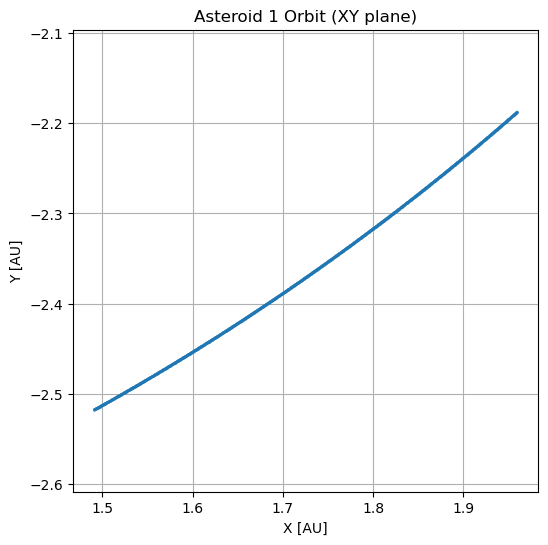

In [6]:
# --------------------------------------------------------
# 7. Quick Orbit Plot for first asteroid
# --------------------------------------------------------
if all_data:
    df = all_data[0]
    plt.figure(figsize=(6,6))
    plt.plot(df['x'], df['y'], marker='.', markersize=2, alpha=0.7)
    plt.title(f"Asteroid {df['identifier'].iloc[0]} Orbit (XY plane)")
    plt.xlabel("X [AU]")
    plt.ylabel("Y [AU]")
    plt.axis('equal')
    plt.grid(True)
    plt.show()
